In [1]:
import os
import sys
import pandas
import numpy

import findspark
findspark.init("/usr/local/spark/spark")

import pyspark
from pyspark.sql.window import Window
import pyspark.sql.functions as func

from pyspark.rdd import reduce
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeansModel, KMeans
from pyspark.ml.linalg import SparseVector, VectorUDT, Vector, Vectors

In [2]:
import matplotlib.pyplot as plt

In [3]:
file_name = "/Users/simondi/PHD/data/data/target_infect_x/query_data/cells_sample_10_normalized.tsv"

In [5]:
conf = pyspark.SparkConf().setMaster("local[*]").set("spark.driver.memory", "4G").set("spark.executor.memory", "4G")
sc = pyspark.SparkContext(conf=conf)
spark = pyspark.sql.SparkSession(sc)

In [6]:
df = spark.read.csv(path=file_name, sep="\t", header='true')

In [7]:
old_cols = df.columns
new_cols = list(map(lambda x: x.replace(".", "_"), old_cols))

df = reduce(
  lambda data, idx: data.withColumnRenamed(old_cols[idx], new_cols[idx]),
  range(len(new_cols)), df)

for i, x in enumerate(new_cols):
    if x.startswith("cells") or x.startswith("perin") or x.startswith("nucl"):
        df = df.withColumn(x, df[x].cast("double"))

df = df.fillna(0)

In [8]:
feature_columns = [x for x in df.columns if x.startswith("cells") or x.startswith("perin") or x.startswith("nucl")]
assembler = VectorAssembler(inputCols=feature_columns,outputCol='features')
data = assembler.transform(df)

In [9]:
data = data.limit(30)

In [10]:
len(data.select("features").take(1)[0][0])

20

In [19]:
km = KMeans().setK(5).setSeed(23)
model = km.fit(data)
kmean_fits.append((k, model, model.computeCost(data)))

NameError: name 'kmean_fits' is not defined

In [10]:
ks =   [x[0] for x in kmean_fits]
mses = [x[2] for x in kmean_fits]

In [13]:
font = {'weight' : 'normal',
        'family':'sans-serif',
        'size'   : 14}|
plt.rc('font', **font)

In [12]:
ax = plt.subplot(111)    
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)

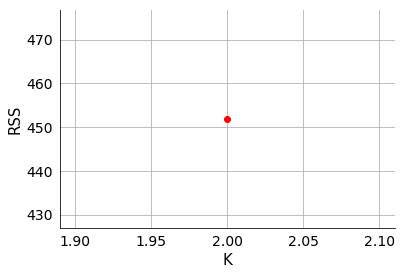

In [13]:
ax.plot(ks, mses, "black")
ax.plot(ks, mses, "or")
plt.xlabel('K', fontsize=15)
plt.ylabel('RSS', fontsize=15)
plt.title('')
ax.grid(True)
plt.show()

In [14]:
model = kmean_fits[[x[0] for x in kmean_fits].index(2)][1]

In [50]:
for center in model.clusterCenters():
    print(len(center), "\t", center)

20 	 [ 1.34861801 -0.97928061 -0.23254553 -0.42810185  0.59812671  1.54364388
  1.02251593 -0.39819992  0.         -0.11992928 -0.14444439  0.22819072
 -0.28974415 -0.13272239  0.98821782  0.82700045 -0.26590491 -0.2699651
 -0.31947819 -0.25657691]
20 	 [-0.38819051  0.21434735  0.15113861  0.25716843 -0.26044247 -0.44063534
 -0.44595767 -0.18039661  0.         -0.18744284 -0.07999921  0.41876248
 -0.25168526 -0.39205639 -0.29445852 -0.32609832 -0.20134209  0.24291029
 -0.14308454 -0.21079735]


In [30]:
data_t = model.transform(data)

In [27]:
data.write.parquet("/Users/simondi/Desktop/test", mode="overwrite")

In [45]:
boot = data.sample(False, 0.5, seed=0).limit(5)

In [50]:
km = KMeans(predictionCol="prediction_{}".format(1)).setK(5).setSeed(23)
boot_model = km.fit(boot)
boot_t = boot_model.transform(boot)

In [52]:
boot_t = boot_t.select(["study", "pathogen", "library", "design", "replicate", "plate", "well", "gene", "sirna", "well_type", "image_idx", "object_idx", "prediction_1"])

In [53]:
boot_t.take(1)

[Row(study='infectx_published', pathogen='listeria', library='a', design='u', replicate='1', plate='kb2-02-1x', well='a01', gene='chka', sirna='s3008', well_type='sirna', image_idx='5', object_idx='168', prediction_1=1)]

In [35]:
data_t.filter("object_idx='3' and well='a03'").take(1)

[Row(study='infectx_published', pathogen='listeria', library='a', design='u', replicate='1', plate='kb2-02-1x', well='a03', gene='chuk', sirna='s3077', well_type='sirna', image_idx='22', object_idx='3', cells_areashape_area=-0.1759633243602963, cells_areashape_eccentricity=0.5342379126324321, cells_areashape_extent=0.3899553758317538, cells_areashape_formfactor=1.2123058704483387, cells_areashape_majoraxislength=-0.014046750018828838, cells_areashape_minoraxislength=-0.29704391296529004, cells_areashape_perimeter=-0.6483579549780818, cells_children_bacteria_count=-0.1896429800085775, cells_children_invasomes_count=0.0, cells_location_center_x=-1.8366954667888513, cells_location_center_y=-0.8547243457041039, cells_neighbors_anglebetweenneighbors_2=1.5222899533347167, cells_neighbors_firstclosestobjectnumber_2=-1.8549162085364432, cells_neighbors_firstclosestxvector_2=-0.018089840382808954, cells_neighbors_firstclosestyvector_2=-1.248662256694484, cells_neighbors_numberofneighbors_2=-0.7

In [ ]:
data_t = model.transform(data)

In [56]:
data_t[["prediction"]].dropDuplicates().take(20)

[Row(prediction=3),
 Row(prediction=2),
 Row(prediction=4),
 Row(prediction=1),
 Row(prediction=0)]

In [108]:
for i in range(5):
    pred = "prediction={}".format(i)
    data_i = data_t.filter(pred)
    data_i.toPandas().to_csv("~/Desktop/bla_{}.tsv".format(i), sep="\t", index=0)

KeyboardInterrupt: 

In [104]:
'prediction={}'.format(1)

'prediction=1'

In [111]:
spark.stop()